In [124]:
# Some imports to get us started
import warnings
warnings.simplefilter('ignore')

# Utilities
import os 
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
random_state = 42 # Ensure reproducible results

# DoWhy
import pygraphviz
from IPython.display import Image, display
import dowhy
from dowhy import CausalModel
import econml


# Generic ML imports
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, average_precision_score, recall_score, f1_score

In [125]:
# I/O Stuff
DATA_FILENAME = "csdh_clean.csv"
DATA_FILEPATH = "/Users/callum/Uni/GitHubRepos/surviving-the-icu/datasets/drain_data/" + DATA_FILENAME
csdh = pd.read_csv(DATA_FILEPATH)

In [126]:
csdh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745 entries, 0 to 744
Data columns (total 58 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 745 non-null    int64  
 1   sex                 745 non-null    int64  
 2   hospital            745 non-null    int64  
 3   diabetes            745 non-null    int64  
 4   dementia            745 non-null    int64  
 5   copd                745 non-null    int64  
 6   stroke              745 non-null    int64  
 7   ihd                 745 non-null    int64  
 8   arrhythmia          745 non-null    int64  
 9   epilepsy            745 non-null    int64  
 10  shunt               745 non-null    int64  
 11  malignancy          745 non-null    int64  
 12  metalvalve          745 non-null    int64  
 13  headinjury          745 non-null    int64  
 14  residence           745 non-null    int64  
 15  mobility            745 non-null    int64  
 16  adm_mrs 

In [127]:
# Mapping bedrest to categorical variable
csdh['bedrest'] = csdh['bedrest'].map({'None':0, '<12hrs':1, '12-24hrs':2, '25-48hrs':3, '>48hrs':4})

In [128]:
features = ['platelet', 'inr', 'stroke', 'antiplatelet', 'ihd', 'age', 'metalvalve', 
            'thickness_sum', 'membranes', 'optype', 'recurrence', 
            'drain', 'hospital', 'bedrest']
csdh = csdh[features]

In [129]:
categorical_features = ['stroke', 'antiplatelet', 'ihd', 'metalvalve', 'membranes', 'optype', 'recurrence',
                        'drain', 'hospital', 'bedrest']
for feature in categorical_features:
    col = pd.Categorical(csdh[feature])
    csdh[feature] = col.codes

In [131]:
csdh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745 entries, 0 to 744
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   platelet       745 non-null    int64  
 1   inr            745 non-null    float64
 2   stroke         745 non-null    int8   
 3   antiplatelet   745 non-null    int8   
 4   ihd            745 non-null    int8   
 5   age            745 non-null    int64  
 6   metalvalve     745 non-null    int8   
 7   thickness_sum  745 non-null    int64  
 8   membranes      745 non-null    int8   
 9   optype         745 non-null    int8   
 10  recurrence     745 non-null    int8   
 11  drain          745 non-null    int8   
 12  hospital       745 non-null    int8   
 13  bedrest        745 non-null    int8   
dtypes: float64(1), int64(3), int8(10)
memory usage: 30.7 KB


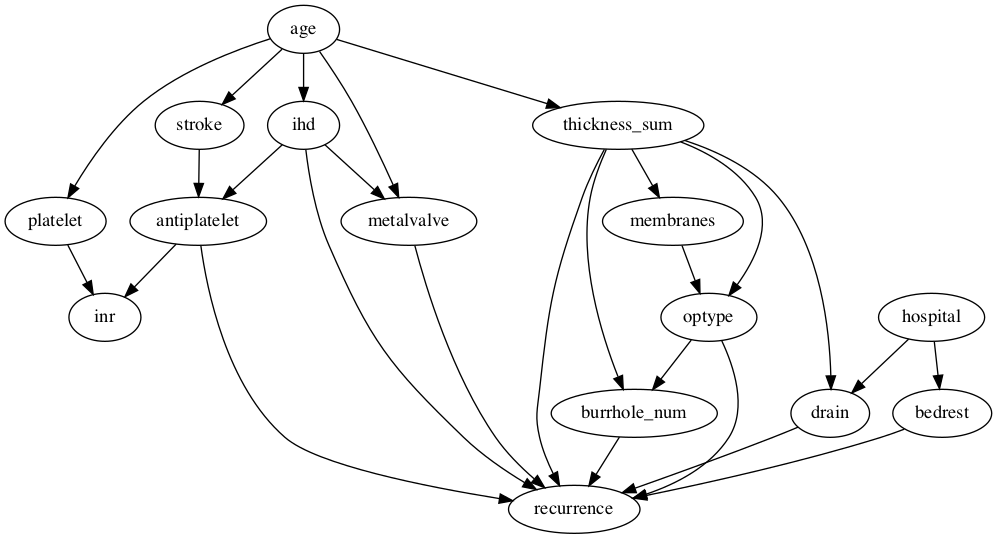

In [4]:
causal_model = CausalModel(data=csdh, 
                          treatment='drain', 
                          outcome='recurrence', 
                          graph='../causal_graphs/treatment_dag.dot'.replace("\n", " "))
causal_model.view_model()
display(Image(filename="causal_model.png"))

In [6]:
csdh.head(10)

,platelet,inr,stroke,antiplatelet,ihd,age,metalvalve,thickness_sum,membranes,optype,recurrence,drain,hospital,bedrest
0,50,1.2,0,0,0,20,0,20,0,1,1.0,0,17,0
1,257,1.1,0,0,0,23,0,6,0,1,0.0,1,1,0
2,259,1.0,0,0,0,23,0,22,0,1,0.0,1,26,3
3,349,1.0,0,0,0,23,0,8,0,1,0.0,0,17,0
4,374,1.0,0,0,0,28,0,10,0,1,0.0,0,26,2
5,262,1.0,0,0,0,29,0,30,1,2,0.0,1,17,2
6,255,1.1,0,0,0,32,0,10,0,1,1.0,1,9,0
7,250,0.9,0,0,0,33,0,25,0,1,0.0,0,1,0
8,428,1.1,0,0,0,34,0,8,0,1,0.0,1,18,2
9,471,1.0,0,0,0,34,0,16,0,1,0.0,1,7,0


## Predicting $Y$ (recurrence) from controls $X, W$

In [78]:
y_rec_full = csdh['recurrence']
X_rec_full = csdh.drop(['drain', 'recurrence'], axis=1)

In [79]:
# Split into validation set and rest
X_rec_rest, X_rec_val, y_rec_rest, y_rec_val = train_test_split(X_rec_full, y_rec_full, 
                                                                test_size=0.15,
                                                                random_state=random_state,
                                                                stratify=y_rec_full)

# Split rest into train and test set
X_rec_train, X_rec_test, y_rec_train, y_rec_test = train_test_split(X_rec_rest, y_rec_rest, 
                                                                    test_size=0.15,
                                                                    random_state=random_state,
                                                                    stratify=y_rec_rest)

In [94]:
names = ['Dummy', 'MNB', 'GNB', 'LR', 'Linear SVM', 'RBF SVM', 'GB', 'RF']

In [95]:
classifiers = [
    DummyClassifier(strategy='most_frequent'),
    MultinomialNB(),
    GaussianNB(),
    LogisticRegression(max_iter=1000),
    SVC(kernel="linear", probability=True, random_state=random_state),
    SVC(kernel='rbf', probability=True, random_state=random_state),
    GradientBoostingClassifier(max_depth=10, n_estimators=50, random_state=random_state),
    RandomForestClassifier(max_depth=10, n_estimators=50, random_state=random_state)
]

In [96]:
# Training 
ca_train_score = {}  # Classification accuracy
prec_train_score = {}
recall_train_score = {}
f1_train_score = {}
ce_train_score = {}  # Cross-entropy

# Validation
ca_val_score = {}
prec_val_score = {}
recall_val_score = {}
f1_val_score = {}
ce_val_score = {}

In [97]:
for name, clf in zip(names, classifiers):
    clf.fit(X_rec_train, y_rec_train)
    
    ca_train_score[name] = clf.score(X_rec_train, y_rec_train)
    prec_train_score[name] = average_precision_score(y_rec_train, clf.predict(X_rec_train))
    recall_train_score[name] = recall_score(y_rec_train, clf.predict(X_rec_train))
    f1_train_score[name] = f1_score(y_rec_train, clf.predict(X_rec_train))
    ce_train_score[name] = log_loss(y_rec_train, clf.predict(X_rec_train))
    
    ca_val_score[name] = clf.score(X_rec_val, y_rec_val)
    prec_val_score[name] = average_precision_score(y_rec_val, clf.predict(X_rec_val))
    recall_val_score[name] = recall_score(y_rec_val, clf.predict(X_rec_val))
    f1_val_score[name] = f1_score(y_rec_val, clf.predict(X_rec_val))
    ce_val_score[name] = log_loss(y_rec_val, clf.predict(X_rec_val))

In [98]:
print('Classification performance on validation set: \n')
print("{0:<10s}   {1:-^43s}   {2:-^43s}".format('','Validation', 'Training'))
print("{0:<10s}{1:>9s}{2:>9s}{3:>9s}{4:>9s}{5:>9s}{6:>9s}{7:>9s}{8:>9s}{9:>9s}{10:>9s}".format(
    'Method', 'Acc\u2191', 'Prec\u2191', 'Recall\u2191', 'F1\u2191', 'LL\u2193',
    'Acc\u2191', 'Prec\u2191', 'Recall\u2191', 'F1\u2191', 'LL\u2193'))
print("-"*(10+10*9))
for clf in names:
    print ("{method:<10s}{val_accuracy:>9.3f}{val_precision:>9.3f}{val_recall:>9.3f}{val_f1:>9.3f}{val_logloss:>8.3f}{train_accuracy:>9.3f}{train_precision:>9.3f}{train_recall:>9.3f}{train_f1:>9.3f}{train_logloss:>9.3f}".format(
        method=clf, val_accuracy=ca_val_score[clf],
        val_precision = prec_val_score[clf],
        val_recall = recall_val_score[clf],
        val_f1 = f1_val_score[clf],
        val_logloss=ce_val_score[clf],
        train_accuracy=ca_train_score[clf], 
        train_precision = prec_train_score[clf],
        train_recall = recall_train_score[clf],
        train_f1 = f1_train_score[clf],
        train_logloss=ce_train_score[clf]))

Classification performance on validation set: 

             ----------------Validation-----------------   -----------------Training------------------
Method         Acc↑    Prec↑  Recall↑      F1↑      LL↓     Acc↑    Prec↑  Recall↑      F1↑      LL↓
----------------------------------------------------------------------------------------------------
Dummy         0.911    0.089    0.000    0.000   3.084    0.907    0.093    0.000    0.000    3.210
MNB           0.741    0.089    0.000    0.000   8.943    0.770    0.111    0.320    0.205    7.961
GNB           0.893    0.138    0.200    0.250   3.701    0.890    0.104    0.080    0.119    3.788
LR            0.911    0.089    0.000    0.000   3.084    0.907    0.093    0.000    0.000    3.210
Linear SVM    0.911    0.089    0.000    0.000   3.084    0.907    0.093    0.000    0.000    3.210
RBF SVM       0.911    0.089    0.000    0.000   3.084    0.907    0.093    0.000    0.000    3.210
GB            0.866    0.089    0.000    0.000 

---
## Predicting $T$ (drain) from controls $X, W$

In [99]:
y_drain_full = csdh['drain']
X_drain_full = csdh.drop(['drain', 'recurrence'], axis=1)

In [100]:
# Split into validation set and rest
X_drain_rest, X_drain_val, y_drain_rest, y_drain_val = train_test_split(X_drain_full, y_drain_full, 
                                                                        test_size=0.15,
                                                                        random_state=random_state,
                                                                        stratify=y_drain_full)

# Split rest into train and test set
X_drain_train, X_drain_test, y_drain_train, y_drain_test = train_test_split(X_drain_rest, y_drain_rest, 
                                                                            test_size=0.15,
                                                                            random_state=random_state,
                                                                            stratify=y_drain_rest)

In [108]:
# Training 
ca_train_score_t = {}  # Classification accuracy
prec_train_score_t = {}
recall_train_score_t = {}
f1_train_score_t = {}
ce_train_score_t = {}  # Cross-entropy

# Validation
ca_val_score_t = {}
prec_val_score_t = {}
recall_val_score_t = {}
f1_val_score_t = {}
ce_val_score_t = {}

In [109]:
for name, clf in zip(names, classifiers):
    clf.fit(X_drain_train, y_drain_train)
    
    ca_train_score_t[name] = clf.score(X_drain_train, y_drain_train)
    prec_train_score_t[name] = average_precision_score(y_drain_train, clf.predict(X_drain_train))
    recall_train_score_t[name] = recall_score(y_drain_train, clf.predict(X_drain_train))
    f1_train_score_t[name] = f1_score(y_drain_train, clf.predict(X_drain_train))
    ce_train_score_t[name] = log_loss(y_drain_train, clf.predict(X_drain_train))
    
    ca_val_score_t[name] = clf.score(X_drain_val, y_drain_val)
    prec_val_score_t[name] = average_precision_score(y_drain_val, clf.predict(X_drain_val))
    recall_val_score_t[name] = recall_score(y_drain_val, clf.predict(X_drain_val))
    f1_val_score_t[name] = f1_score(y_drain_val, clf.predict(X_drain_val))
    ce_val_score_t[name] = log_loss(y_drain_val, clf.predict(X_drain_val))

In [111]:
print('Classification performance on validation set: \n')
print("{0:<10s}   {1:-^43s}   {2:-^43s}".format('','Validation', 'Training'))
print("{0:<10s}{1:>9s}{2:>9s}{3:>9s}{4:>9s}{5:>9s}{6:>9s}{7:>9s}{8:>9s}{9:>9s}{10:>9s}".format(
    'Method', 'Acc\u2191', 'Prec\u2191', 'Recall\u2191', 'F1\u2191', 'LL\u2193',
    'Acc\u2191', 'Prec\u2191', 'Recall\u2191', 'F1\u2191', 'LL\u2193'))
print("-"*(10+10*9))
for clf in names:
    print ("{method:<10s}{val_accuracy:>9.3f}{val_precision:>9.3f}{val_recall:>9.3f}{val_f1:>9.3f}{val_logloss:>8.3f}{train_accuracy:>9.3f}{train_precision:>9.3f}{train_recall:>9.3f}{train_f1:>9.3f}{train_logloss:>9.3f}".format(
        method=clf, val_accuracy=ca_val_score_t[clf],
        val_precision = prec_val_score_t[clf],
        val_recall = recall_val_score_t[clf],
        val_f1 = f1_val_score_t[clf],
        val_logloss=ce_val_score_t[clf],
        train_accuracy=ca_train_score_t[clf], 
        train_precision = prec_train_score_t[clf],
        train_recall = recall_train_score_t[clf],
        train_f1 = f1_train_score_t[clf],
        train_logloss=ce_train_score_t[clf]))

Classification performance on validation set: 

             ----------------Validation-----------------   -----------------Training------------------
Method         Acc↑    Prec↑  Recall↑      F1↑      LL↓     Acc↑    Prec↑  Recall↑      F1↑      LL↓
----------------------------------------------------------------------------------------------------
Dummy         0.839    0.839    1.000    0.913   5.551    0.835    0.835    1.000    0.910    5.714
MNB           0.661    0.847    0.723    0.782  11.719    0.710    0.869    0.755    0.813   10.015
GNB           0.741    0.848    0.840    0.845   8.943    0.758    0.863    0.837    0.853    8.346
LR            0.848    0.847    1.000    0.917   5.243    0.836    0.837    0.998    0.911    5.650
Linear SVM    0.839    0.839    1.000    0.913   5.551    0.835    0.835    1.000    0.910    5.714
RBF SVM       0.839    0.839    1.000    0.913   5.551    0.835    0.835    1.000    0.910    5.714
GB            0.812    0.853    0.936    0.893 

In [114]:
clf = RandomForestClassifier(max_depth=10, n_estimators=50,random_state=random_state)
clf.fit(X_drain_train, y_drain_train)
ca_rf_test = clf.score(X_drain_test, y_drain_test)
prec_rf_test = average_precision_score(y_drain_test, clf.predict(X_drain_test))
recall_rf_test = recall_score(y_drain_test, clf.predict(X_drain_test))
f1_rf_test = f1_score(y_drain_test, clf.predict(X_drain_test))
ce_rf_test = log_loss(y_drain_test, clf.predict(X_drain_test))

print("Performance on the test set")
print("Classification accuracy:", ca_rf_test)
print("Precision:", prec_rf_test)
print("Recall:", recall_rf_test)
print("F1 Score:", f1_rf_test)
print("Log-loss:", ce_rf_test)

Performance on the test set
Classification accuracy: 0.8526315789473684
Precision: 0.8494623655913979
Recall: 1.0
F1 Score: 0.9186046511627907
Log-loss: 5.090042777818656
